<a href="https://colab.research.google.com/github/ibrahimelkholly74-web/AI_Platforms_Fall_2025_2026/blob/main/Assigment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu

Loading Fashion-MNIST Dataset...
Training samples: 60000
Test samples: 10000

Building Model...
Total parameters: 235,146

Training...
Epoch 1/10 - Train Loss: 0.5210, Train Acc: 81.34% - Test Loss: 0.4140, Test Acc: 85.04%
Epoch 2/10 - Train Loss: 0.3704, Train Acc: 86.37% - Test Loss: 0.4006, Test Acc: 85.41%
Epoch 3/10 - Train Loss: 0.3304, Train Acc: 87.73% - Test Loss: 0.3550, Test Acc: 87.20%
Epoch 4/10 - Train Loss: 0.3071, Train Acc: 88.62% - Test Loss: 0.3572, Test Acc: 87.12%
Epoch 5/10 - Train Loss: 0.2899, Train Acc: 89.22% - Test Loss: 0.3471, Test Acc: 87.43%
Epoch 6/10 - Train Loss: 0.2745, Train Acc: 89.71% - Test Loss: 0.3343, Test Acc: 87.90%
Epoch 7/10 - Train Loss: 0.2590, Train Acc: 90.30% - Test Loss: 0.3465, Test Acc: 87.38%
Epoch 8/10 - Train Loss: 0.2501, Train Acc: 90.50% - Test Loss: 0.3456, Test Acc: 87.38%
Epoch 9/10 - Train Loss: 0.2405, Train Acc: 90.91% - Test Loss: 0.3222, Test Acc: 88.85%
Epoch 10/10 - Train Loss: 0.2300, Train Acc: 

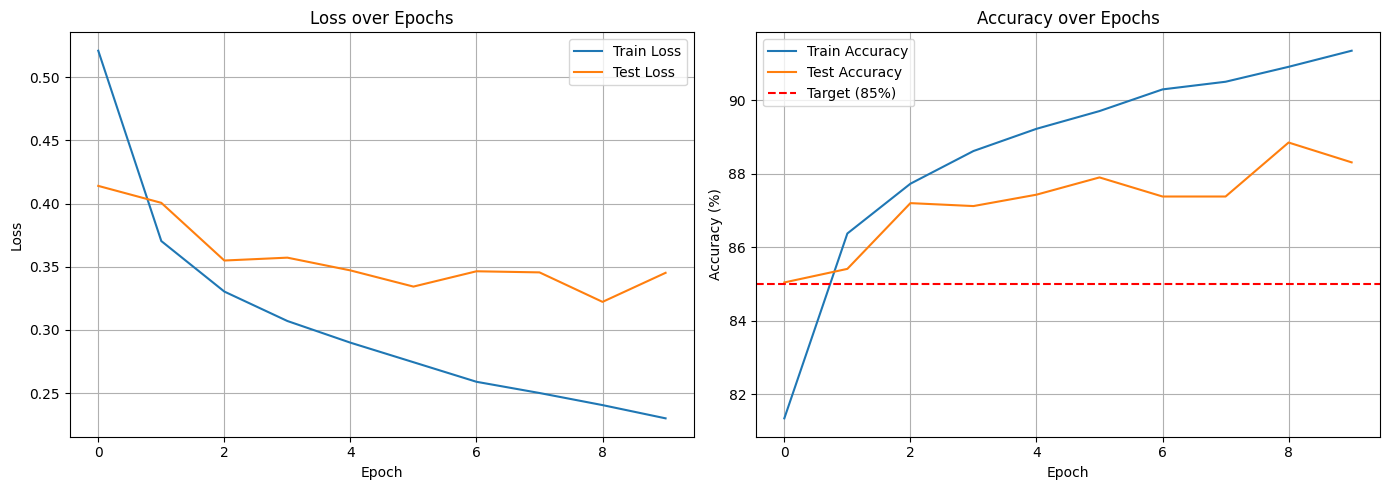


Generating Confusion Matrix...


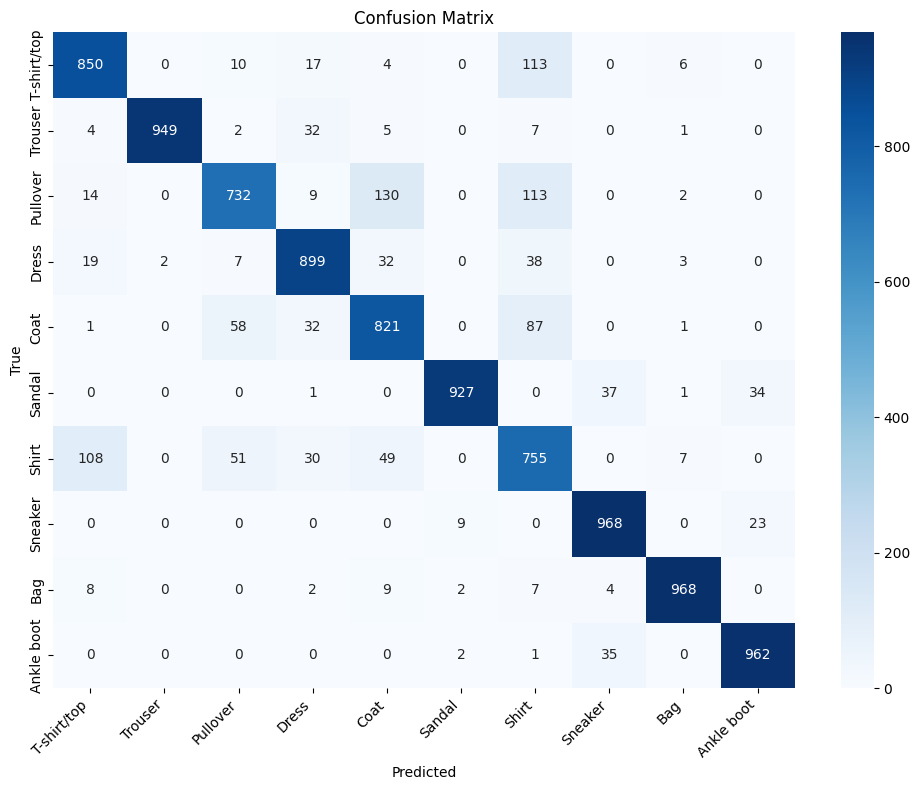


Showing Example Predictions...


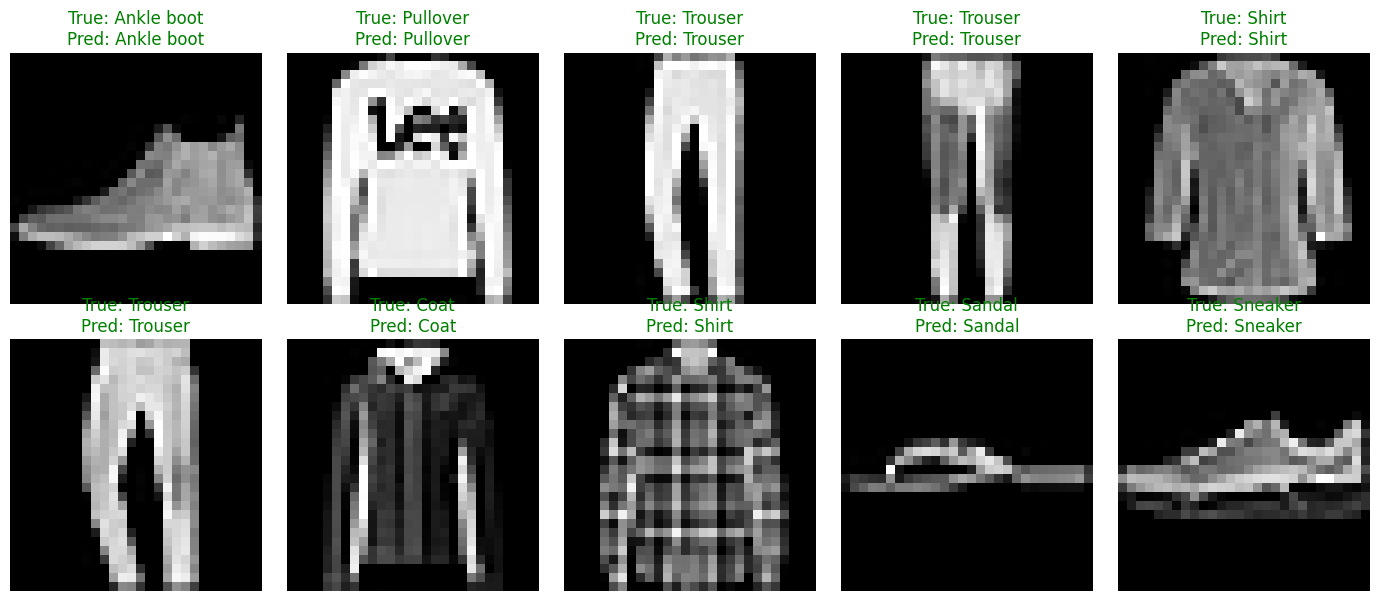

In [4]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Setup
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load Data
print("\nLoading Fashion-MNIST Dataset...")
transform = transforms.ToTensor()

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Define Model
print("\nBuilding Model...")

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train
print("\nTraining...")
epochs = 10
train_acc_history = []
test_acc_history = []
train_loss_history = []
test_loss_history = []

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = train_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Testing
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

    print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

print(f'\nFinal Test Accuracy: {test_acc:.2f}%')

# Plot Training Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_loss_history, label='Train Loss')
ax1.plot(test_loss_history, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss over Epochs')
ax1.legend()
ax1.grid(True)

ax2.plot(train_acc_history, label='Train Accuracy')
ax2.plot(test_acc_history, label='Test Accuracy')
ax2.axhline(y=85, color='r', linestyle='--', label='Target (85%)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy over Epochs')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# Confusion Matrix
print("\nGenerating Confusion Matrix...")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Example Predictions
print("\nShowing Example Predictions...")
model.eval()
images, labels = next(iter(test_loader))
images_device = images.to(device)

with torch.no_grad():
    outputs = model(images_device)
    _, predicted = outputs.max(1)

predicted = predicted.cpu()

fig, axes = plt.subplots(2, 5, figsize=(14, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    true_label = class_names[labels[i]]
    pred_label = class_names[predicted[i]]
    color = 'green' if labels[i] == predicted[i] else 'red'
    ax.set_title(f'True: {true_label}\nPred: {pred_label}', color=color)
    ax.axis('off')

plt.tight_layout()
plt.savefig('predictions.png')
plt.show()